# Extended Persistence

Mathieu Carrière, https://mathieucarriere.github.io/website/

In [1]:
import numpy as np
import gudhi as gd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import networkx as nx

In this notebook, we will show how to use Gudhi in order to compute an extension of persistence called **extended persistence**. The motivation of extended persistence is that the usual of way of computing persistence, that is, by looking at the sublevel sets of a function, might miss important information, and is somehow limited.

## Illustration on graph

Consider the following graph:

In [2]:
st = gd.SimplexTree()

In [3]:
st.insert([0,1])
st.insert([1,2])
st.insert([1,3])
st.insert([2,4])
st.insert([3,4])
st.insert([4,5])
st.insert([2,6])
st.insert([3,7])
st.assign_filtration([0], 0.)
st.assign_filtration([1], 1.)
st.assign_filtration([2], 2.)
st.assign_filtration([3], 3.)
st.assign_filtration([4], 4.)
st.assign_filtration([5], 5.)
st.assign_filtration([6], 0.5)
st.assign_filtration([7], 4.5)
_ = st.make_filtration_non_decreasing()

Let's visualize the graph using the filtration value as the height function.

In [4]:
G = nx.Graph()
for (splx,_) in st.get_skeleton(1):
    if len(splx) == 1:
        G.add_node(splx[0])
    if len(splx) == 2:
        G.add_edge(splx[0], splx[1])
pos = {}
for idxv, v in enumerate(G.nodes()):
    y = st.filtration([v])
    if v == 2:
        x = -1.
    elif v == 6:
        x = -2.
    elif v == 3:
        x = 1.
    elif v == 7:
        x = 2.
    else:
        x = 0.
    pos[v] = [x,y]

In [5]:
# Note: %matplotlib notebook allows for iteractive 3D plot.
#%matplotlib notebook
%matplotlib inline

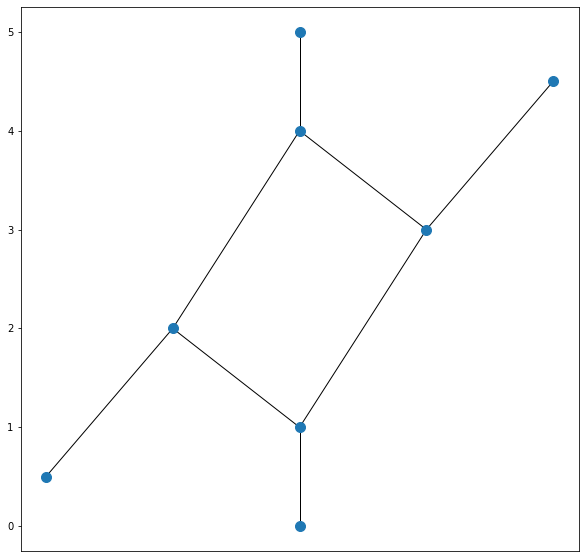

In [6]:
fig, ax = plt.subplots(figsize=(10,10))
nx.draw(G, pos=pos, node_size=100, ax=ax)
limits=plt.axis('on')
ax.tick_params(left=True, bottom=False, labelleft=True, labelbottom=False)
plt.show()

The topological features of this graph are these ones: one connected component, one branch pointing downward, one pointing upward, and one loop.

Now let's see what its (ordinary) persistence diagram looks like.

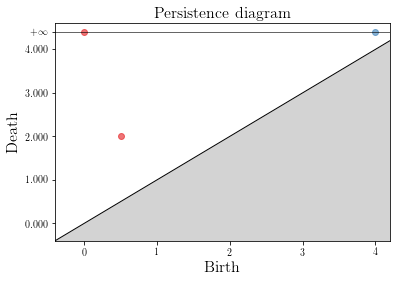

In [7]:
dgm = st.persistence(persistence_dim_max=True)
gd.plot_persistence_diagram(dgm)
plt.show()

The branch pointing downward has been detected as a point in dimension 0 with coordinates (0.5, 2.), which correspond to the lowest and highest parts of the branch respectively. The connected component generates a point in dimension 0 with infinite persistence (and abscissa 0., which corresponds to the lowest part of the component). Similarly, the loop generates a point in dimension 1 with infinite persistence (and abscissa 4, which corresponds to the highest part of the loop). Hence, the sizes of the loop and the connected component are missed since the corresponding points have infinite persistence. Moreover, the branch pointing upward is not detected at all.   

To handle this, we can use **extended persistence**: in addition to the sublevel sets of $f$, i.e., the family $F_\alpha=\{x\in X\,:\,f(x)\leq \alpha\}$, we will also use the **superlevel sets** of $f$, i.e., the family $F^\alpha=\{x\in X\,:\,f(x)\geq \alpha\}$ (which can be interpreted as the sublevel sets of $-f$). More formally, extended persistence extends the usual persistence module induced by applying the __homology functor__ to the canonical inclusions $F_\alpha \subseteq F_\beta$, $\alpha\leq\beta$, by also applying the __relative homology functor__ to the inclusions of pairs of spaces $(X,F^\beta)\subseteq (X,F^\alpha)$, $\alpha\leq\beta$. See this [seminal paper](https://link.springer.com/article/10.1007/s10208-008-9027-z) for more details.

Intuitively, when applied to the previous graph, the branch pointing upward will now be detected as a branch pointing downward in the superlevel sets. Moreover, the connected component and the loop will have death times assigned by relative homology.

In order to implement extended persistence, Gudhi first maps all ordinary filtration values within the interval [-2,-1], then cone the whole simplicial complex (it has been proved [here](https://link.springer.com/article/10.1007/s10208-008-9027-z) (see Section 6) that coning is roughly equivalent to relative homology), and map all coned filtration values to [1,2]. The vertex used for coning is assigned filtration value -3.

In [8]:
st.extend_filtration()

In [9]:
for (s,f) in st.get_filtration():
    print(s,f)

[8] -3.0
[0] -2.0
[6] -1.9
[1] -1.8
[0, 1] -1.8
[2] -1.6
[1, 2] -1.6
[2, 6] -1.6
[3] -1.4
[1, 3] -1.4
[4] -1.2
[2, 4] -1.2
[3, 4] -1.2
[7] -1.1
[3, 7] -1.1
[5] -1.0
[4, 5] -1.0
[5, 8] 1.0
[7, 8] 1.1
[4, 8] 1.2
[4, 5, 8] 1.2
[3, 8] 1.4
[3, 4, 8] 1.4
[3, 7, 8] 1.4
[2, 8] 1.6
[2, 4, 8] 1.6
[1, 8] 1.8
[1, 2, 8] 1.8
[1, 3, 8] 1.8
[6, 8] 1.9
[2, 6, 8] 1.9
[0, 8] 2.0
[0, 1, 8] 2.0


We can now use these new filtration values to compute extended persistence! Even though the filtration values in the simplex tree have been modified, Gudhi has internally saved the minimum and maximum of the old filtration values so that the output of extended persistence can be reverted to the old filtration values. Note however that numerical errors can be introduced by this process: usually the values in the extended persistence diagrams are slightly different than the ones in the old filtration.

In [10]:
dgms = st.extended_persistence(min_persistence=1e-5)

In [11]:
print(dgms)

[[(0, (0.5000000000000004, 1.9999999999999996))], [(1, (4.5, 3.0000000000000004))], [(0, (0.0, 5.0))], [(1, (4.0, 0.9999999999999998))]]


You probably noticed that extended persistence outputs four persistence diagrams instead of just one. This is because the topological structures (more formally the summands in the decomposition of the extended persistence module) have been divided between the ones that are born and die in the old filtration (called **ordinary**), the ones that are born in the old filtration and die in the new coned filtration (called **extended**), and the ones that are born and die in the new coned filtration (called **relative**). Moreover, since the thresholds in the new coned filtration are decreasing, death times for extended and relative point can actually be smaller than birth times (actually they are always smaller for relative points). Hence extended topological structures are also divided between the ones with birth times smaller than death times (called **extended+**) and the ones with death times smaller than birth times (called **extended-**). Let's look at these guys:

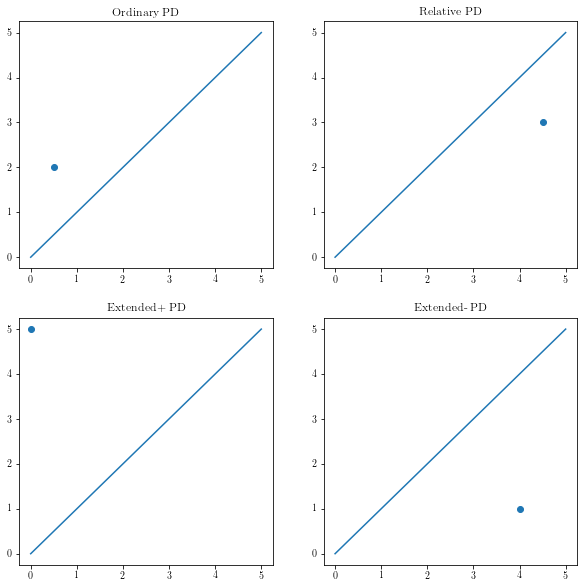

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(10,10))
axs[0,0].scatter([dgms[0][i][1][0] for i in range(len(dgms[0]))], [dgms[0][i][1][1] for i in range(len(dgms[0]))])
axs[0,0].plot([0,5],[0,5])
axs[0,0].set_title("Ordinary PD")
axs[0,1].scatter([dgms[1][i][1][0] for i in range(len(dgms[1]))], [dgms[1][i][1][1] for i in range(len(dgms[1]))])
axs[0,1].plot([0,5],[0,5])
axs[0,1].set_title("Relative PD")
axs[1,0].scatter([dgms[2][i][1][0] for i in range(len(dgms[2]))], [dgms[2][i][1][1] for i in range(len(dgms[2]))])
axs[1,0].plot([0,5],[0,5])
axs[1,0].set_title("Extended+ PD")
axs[1,1].scatter([dgms[3][i][1][0] for i in range(len(dgms[3]))], [dgms[3][i][1][1] for i in range(len(dgms[3]))])
axs[1,1].plot([0,5],[0,5])
axs[1,1].set_title("Extended- PD")
plt.show()

There is now one point for each topological structure of the graph, plus they live in different persistence diagrams!

## Application on 3D shape

Let's look at something less trivial now. Consider the following 3D shape:

In [13]:
triangles = np.loadtxt("datasets/human.off", dtype=int)[:,1:]
coords = np.loadtxt("datasets/human.txt", dtype=float)

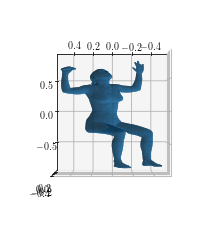

In [14]:
fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(1, 2, 1, projection="3d")
ax.plot_trisurf(coords[:,0], coords[:,1], coords[:,2], triangles=triangles)
ax.view_init(-90, 90)
plt.show()

We are going to study the persistence diagram of the height function.

In [15]:
st = gd.SimplexTree()

In [16]:
for i in range(len(triangles)):
    st.insert([v for v in triangles[i,:]], -10)
for i in range(len(coords)):
    st.assign_filtration([i], coords[i,1])
_ = st.make_filtration_non_decreasing()

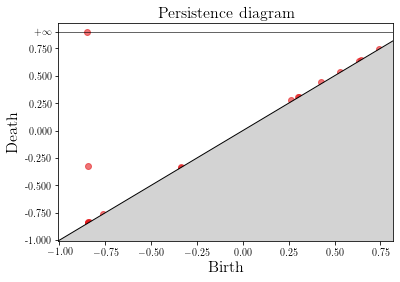

In [17]:
dgm = st.persistence(persistence_dim_max=True)
gd.plot_persistence_diagram([pt for pt in dgm if pt[0] == 0])
plt.show()

The problem is the same as before: the arms do not generate any point in the ordinary persistence diagram, and the connected component has infinite persistence. So let's try extended persistence!

In [18]:
st.extend_filtration()
dgms = st.extended_persistence(min_persistence=1e-5)

Again, the arms should generate topological structures in dimension 1 (since they create cycles in relative homology), one of the leg should create an ordinary structure in dimension 0 (the other leg is actually part of the whole connected component), while the connected component and the void inside the shape should create extended structures in dimensions 0 and 2 respectively.

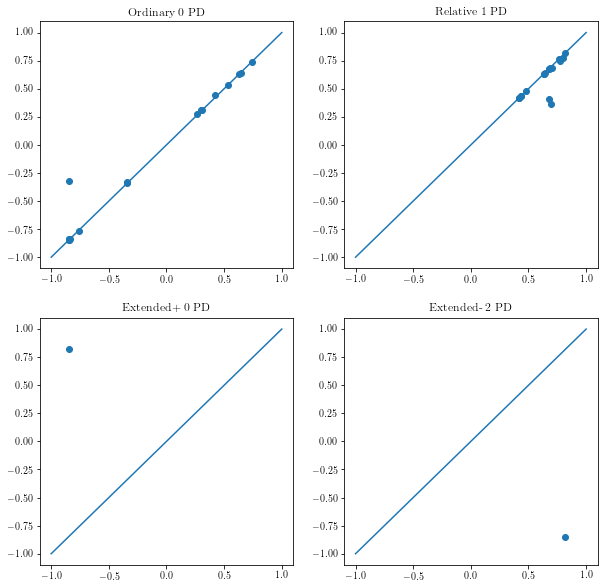

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(10,10))
axs[0,0].scatter([dgms[0][i][1][0] for i in range(len(dgms[0])) if dgms[0][i][0] == 0], 
                 [dgms[0][i][1][1] for i in range(len(dgms[0])) if dgms[0][i][0] == 0])
axs[0,0].plot([-1,1],[-1,1])
axs[0,0].set_title("Ordinary 0 PD")
axs[0,1].scatter([dgms[1][i][1][0] for i in range(len(dgms[1])) if dgms[1][i][0] == 1], 
                 [dgms[1][i][1][1] for i in range(len(dgms[1])) if dgms[1][i][0] == 1])
axs[0,1].plot([-1,1],[-1,1])
axs[0,1].set_title("Relative 1 PD")
axs[1,0].scatter([dgms[2][i][1][0] for i in range(len(dgms[2])) if dgms[2][i][0] == 0], 
                 [dgms[2][i][1][1] for i in range(len(dgms[2])) if dgms[2][i][0] == 0])
axs[1,0].plot([-1,1],[-1,1])
axs[1,0].set_title("Extended+ 0 PD")
axs[1,1].scatter([dgms[3][i][1][0] for i in range(len(dgms[3])) if dgms[3][i][0] == 2], 
                 [dgms[3][i][1][1] for i in range(len(dgms[3])) if dgms[3][i][0] == 2])
axs[1,1].plot([-1,1],[-1,1])
axs[1,1].set_title("Extended- 2 PD")
plt.show()

Indeed, we can clearly see the two arms in the relative 1 persistence diagram, as well as the topological structures in the other persistence diagrams!

## Symmetry theorems

Also, note that for a smooth manifold like this 3D shape, there exist symmetry theorems for extended persistence, described [here](https://link.springer.com/article/10.1007/s10208-008-9027-z) (see Section 7). Basically, since the intrinsic dimension of our 3D shape is 2 (it is a surface), one should have, for all dimensions $r$, and up to reflection across the minor diagonal (that is, the transformation $(x,y)\mapsto (-y,-x)$) and/or reflection across the principal diagonal (that is, the transformation $(x,y)\mapsto (y,x)$): 

(1) $\text{Ordinary}_r(f) = \text{Ordinary}_{1−r}(−f)$

(2) $\text{Extended}_r(f) = \text{Extended}_{2−r}(−f)$

(3) $\text{Relative}_r(f) = \text{Relative}_{3−r}(−f)$

In [20]:
st2 = gd.SimplexTree()

In [21]:
for i in range(len(triangles)):
    st2.insert([v for v in triangles[i,:]], -10)
for i in range(len(coords)):
    st2.assign_filtration([i], -coords[i,1])
_ = st2.make_filtration_non_decreasing()

In [22]:
st2.extend_filtration()
dgms2 = st2.extended_persistence(min_persistence=1e-5)

Let's check (1) for $r = 0$ and $r=1$.

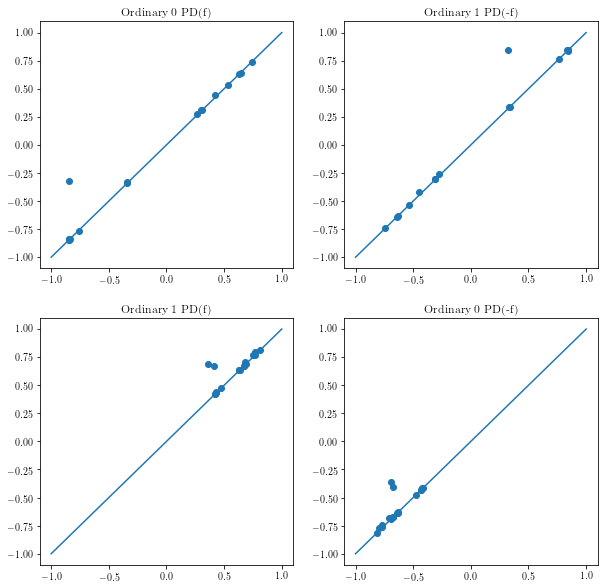

In [23]:
fig, axs = plt.subplots(2, 2, figsize=(10,10))
axs[0,0].scatter([dgms[0][i][1][0] for i in range(len(dgms[0])) if dgms[0][i][0] == 0], 
                 [dgms[0][i][1][1] for i in range(len(dgms[0])) if dgms[0][i][0] == 0])
axs[0,0].plot([-1,1],[-1,1])
axs[0,0].set_title("Ordinary 0 PD(f)")
axs[0,1].scatter([dgms2[0][i][1][0] for i in range(len(dgms2[0])) if dgms2[0][i][0] == 1], 
                 [dgms2[0][i][1][1] for i in range(len(dgms2[0])) if dgms2[0][i][0] == 1])
axs[0,1].plot([-1,1],[-1,1])
axs[0,1].set_title("Ordinary 1 PD(-f)")
axs[1,0].scatter([dgms[0][i][1][0] for i in range(len(dgms[0])) if dgms[0][i][0] == 1], 
                 [dgms[0][i][1][1] for i in range(len(dgms[0])) if dgms[0][i][0] == 1])
axs[1,0].plot([-1,1],[-1,1])
axs[1,0].set_title("Ordinary 1 PD(f)")
axs[1,1].scatter([dgms2[0][i][1][0] for i in range(len(dgms2[0])) if dgms2[0][i][0] == 0], 
                 [dgms2[0][i][1][1] for i in range(len(dgms2[0])) if dgms2[0][i][0] == 0])
axs[1,1].plot([-1,1],[-1,1])
axs[1,1].set_title("Ordinary 0 PD(-f)")
plt.show()

Let's check (3) for $r = 1$ and $r=2$.

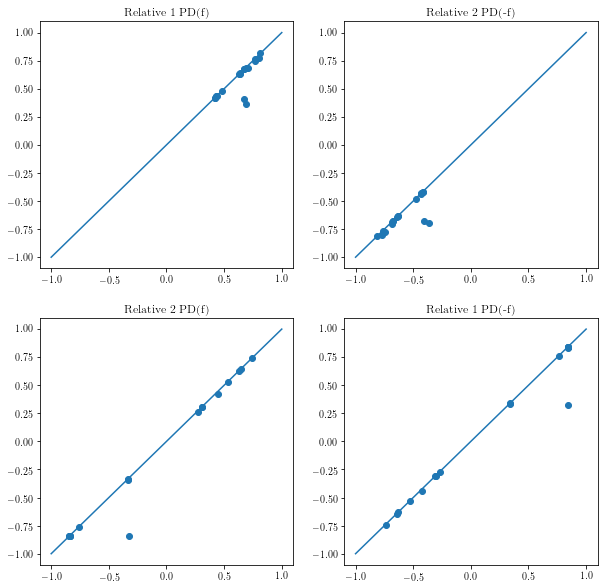

In [24]:
fig, axs = plt.subplots(2, 2, figsize=(10,10))
axs[0,0].scatter([dgms[1][i][1][0] for i in range(len(dgms[1])) if dgms[1][i][0] == 1], 
                 [dgms[1][i][1][1] for i in range(len(dgms[1])) if dgms[1][i][0] == 1])
axs[0,0].plot([-1,1],[-1,1])
axs[0,0].set_title("Relative 1 PD(f)")
axs[0,1].scatter([dgms2[1][i][1][0] for i in range(len(dgms2[1])) if dgms2[1][i][0] == 2], 
                 [dgms2[1][i][1][1] for i in range(len(dgms2[1])) if dgms2[1][i][0] == 2])
axs[0,1].plot([-1,1],[-1,1])
axs[0,1].set_title("Relative 2 PD(-f)")
axs[1,0].scatter([dgms[1][i][1][0] for i in range(len(dgms[1])) if dgms[1][i][0] == 2], 
                 [dgms[1][i][1][1] for i in range(len(dgms[1])) if dgms[1][i][0] == 2])
axs[1,0].plot([-1,1],[-1,1])
axs[1,0].set_title("Relative 2 PD(f)")
axs[1,1].scatter([dgms2[1][i][1][0] for i in range(len(dgms2[1])) if dgms2[1][i][0] == 1], 
                 [dgms2[1][i][1][1] for i in range(len(dgms2[1])) if dgms2[1][i][0] == 1])
axs[1,1].plot([-1,1],[-1,1])
axs[1,1].set_title("Relative 1 PD(-f)")
plt.show()

Let's check (2) for $r = 0$ and $r=2$.

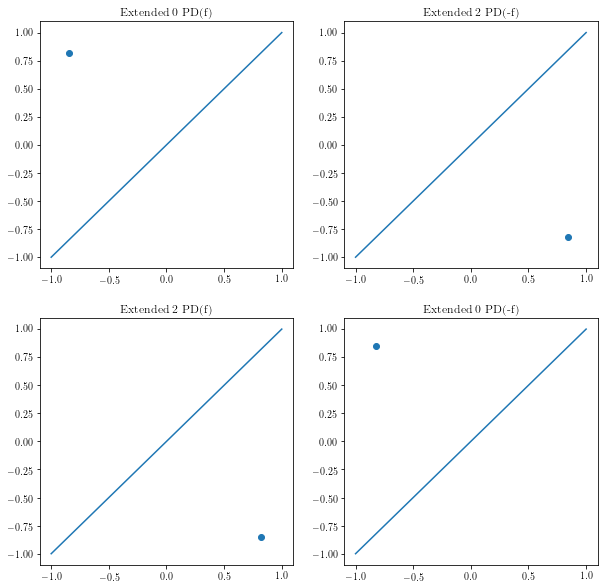

In [25]:
fig, axs = plt.subplots(2, 2, figsize=(10,10))
axs[0,0].scatter([dgms[2][i][1][0] for i in range(len(dgms[2])) if dgms[2][i][0] == 0] + 
                 [dgms[3][i][1][0] for i in range(len(dgms[3])) if dgms[3][i][0] == 0], 
                 [dgms[2][i][1][1] for i in range(len(dgms[2])) if dgms[2][i][0] == 0] +
                 [dgms[3][i][1][1] for i in range(len(dgms[3])) if dgms[3][i][0] == 0])
axs[0,0].plot([-1,1],[-1,1])
axs[0,0].set_title("Extended 0 PD(f)")
axs[0,1].scatter([dgms2[2][i][1][0] for i in range(len(dgms2[2])) if dgms2[2][i][0] == 2] + 
                 [dgms2[3][i][1][0] for i in range(len(dgms2[3])) if dgms2[3][i][0] == 2], 
                 [dgms2[2][i][1][1] for i in range(len(dgms2[2])) if dgms2[2][i][0] == 2] + 
                 [dgms2[3][i][1][1] for i in range(len(dgms2[3])) if dgms2[3][i][0] == 2])
axs[0,1].plot([-1,1],[-1,1])
axs[0,1].set_title("Extended 2 PD(-f)")
axs[1,0].scatter([dgms[2][i][1][0] for i in range(len(dgms[2])) if dgms[2][i][0] == 2] + 
                 [dgms[3][i][1][0] for i in range(len(dgms[3])) if dgms[3][i][0] == 2], 
                 [dgms[2][i][1][1] for i in range(len(dgms[2])) if dgms[2][i][0] == 2] +
                 [dgms[3][i][1][1] for i in range(len(dgms[3])) if dgms[3][i][0] == 2])
axs[1,0].plot([-1,1],[-1,1])
axs[1,0].set_title("Extended 2 PD(f)")
axs[1,1].scatter([dgms2[2][i][1][0] for i in range(len(dgms2[2])) if dgms2[2][i][0] == 0] + 
                 [dgms2[3][i][1][0] for i in range(len(dgms2[3])) if dgms2[3][i][0] == 0], 
                 [dgms2[2][i][1][1] for i in range(len(dgms2[2])) if dgms2[2][i][0] == 0] + 
                 [dgms2[3][i][1][1] for i in range(len(dgms2[3])) if dgms2[3][i][0] == 0])
axs[1,1].plot([-1,1],[-1,1])
axs[1,1].set_title("Extended 0 PD(-f)")
plt.show()

Moreover, some additional symmetry results were proved in [this work](https://www.mrzv.org/publications/zigzags/socg09/) (again, up to the reflections defined above):

(4) $\text{Ordinary}_r(f)    =   \text{Relative}_{r+1}(-f)$

(5) $\text{Extended}_r(f)    =    \text{Extended}_r(-f)$

(6) $\text{Relative}_r(f)    =    \text{Ordinary}_{r-1}(-f)$

Let's check (4) for $r = 0$ and $r=1$.

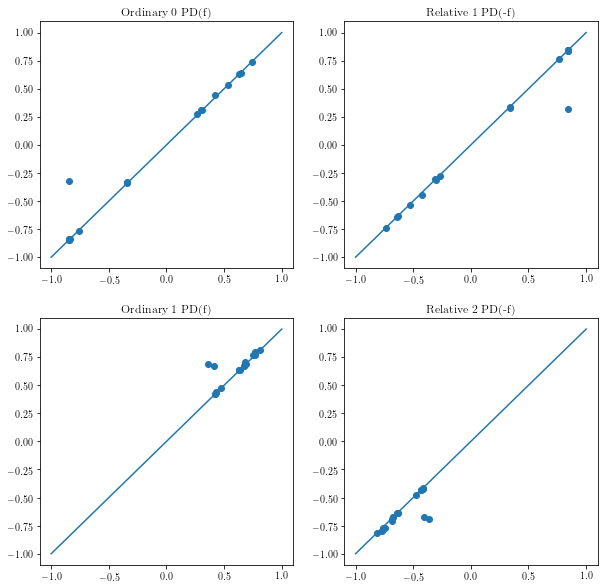

In [26]:
fig, axs = plt.subplots(2, 2, figsize=(10,10))
axs[0,0].scatter([dgms[0][i][1][0] for i in range(len(dgms[0])) if dgms[0][i][0] == 0], 
                 [dgms[0][i][1][1] for i in range(len(dgms[0])) if dgms[0][i][0] == 0])
axs[0,0].plot([-1,1],[-1,1])
axs[0,0].set_title("Ordinary 0 PD(f)")
axs[0,1].scatter([dgms2[1][i][1][0] for i in range(len(dgms2[1])) if dgms2[1][i][0] == 1], 
                 [dgms2[1][i][1][1] for i in range(len(dgms2[1])) if dgms2[1][i][0] == 1])
axs[0,1].plot([-1,1],[-1,1])
axs[0,1].set_title("Relative 1 PD(-f)")
axs[1,0].scatter([dgms[0][i][1][0] for i in range(len(dgms[0])) if dgms[0][i][0] == 1], 
                 [dgms[0][i][1][1] for i in range(len(dgms[0])) if dgms[0][i][0] == 1])
axs[1,0].plot([-1,1],[-1,1])
axs[1,0].set_title("Ordinary 1 PD(f)")
axs[1,1].scatter([dgms2[1][i][1][0] for i in range(len(dgms2[1])) if dgms2[1][i][0] == 2], 
                 [dgms2[1][i][1][1] for i in range(len(dgms2[1])) if dgms2[1][i][0] == 2])
axs[1,1].plot([-1,1],[-1,1])
axs[1,1].set_title("Relative 2 PD(-f)")
plt.show()

Let's check (6) for $r = 1$ and $r=2$.

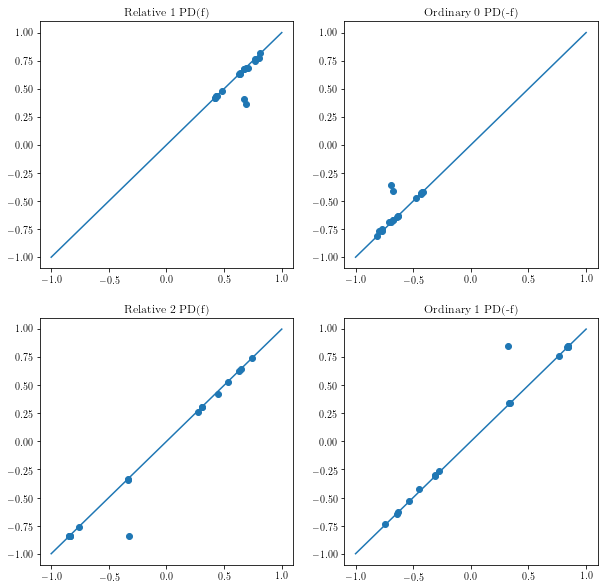

In [27]:
fig, axs = plt.subplots(2, 2, figsize=(10,10))
axs[0,0].scatter([dgms[1][i][1][0] for i in range(len(dgms[1])) if dgms[1][i][0] == 1], 
                 [dgms[1][i][1][1] for i in range(len(dgms[1])) if dgms[1][i][0] == 1])
axs[0,0].plot([-1,1],[-1,1])
axs[0,0].set_title("Relative 1 PD(f)")
axs[0,1].scatter([dgms2[0][i][1][0] for i in range(len(dgms2[0])) if dgms2[0][i][0] == 0], 
                 [dgms2[0][i][1][1] for i in range(len(dgms2[0])) if dgms2[0][i][0] == 0])
axs[0,1].plot([-1,1],[-1,1])
axs[0,1].set_title("Ordinary 0 PD(-f)")
axs[1,0].scatter([dgms[1][i][1][0] for i in range(len(dgms[1])) if dgms[1][i][0] == 2], 
                 [dgms[1][i][1][1] for i in range(len(dgms[1])) if dgms[1][i][0] == 2])
axs[1,0].plot([-1,1],[-1,1])
axs[1,0].set_title("Relative 2 PD(f)")
axs[1,1].scatter([dgms2[0][i][1][0] for i in range(len(dgms2[0])) if dgms2[0][i][0] == 1], 
                 [dgms2[0][i][1][1] for i in range(len(dgms2[0])) if dgms2[0][i][0] == 1])
axs[1,1].plot([-1,1],[-1,1])
axs[1,1].set_title("Ordinary 1 PD(-f)")
plt.show()

Let's check (5) for $r = 0$ and $r=2$.

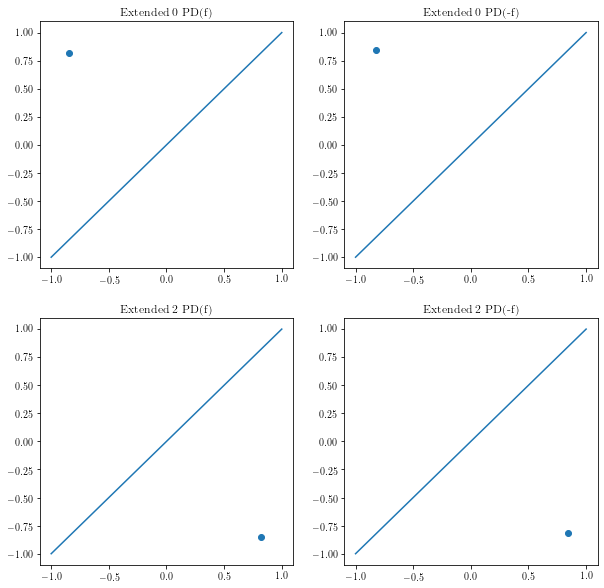

In [28]:
fig, axs = plt.subplots(2, 2, figsize=(10,10))
axs[0,0].scatter([dgms[2][i][1][0] for i in range(len(dgms[2])) if dgms[2][i][0] == 0] + 
                 [dgms[3][i][1][0] for i in range(len(dgms[3])) if dgms[3][i][0] == 0], 
                 [dgms[2][i][1][1] for i in range(len(dgms[2])) if dgms[2][i][0] == 0] +
                 [dgms[3][i][1][1] for i in range(len(dgms[3])) if dgms[3][i][0] == 0])
axs[0,0].plot([-1,1],[-1,1])
axs[0,0].set_title("Extended 0 PD(f)")
axs[0,1].scatter([dgms2[2][i][1][0] for i in range(len(dgms2[2])) if dgms2[2][i][0] == 0] + 
                 [dgms2[3][i][1][0] for i in range(len(dgms2[3])) if dgms2[3][i][0] == 0], 
                 [dgms2[2][i][1][1] for i in range(len(dgms2[2])) if dgms2[2][i][0] == 0] + 
                 [dgms2[3][i][1][1] for i in range(len(dgms2[3])) if dgms2[3][i][0] == 0])
axs[0,1].plot([-1,1],[-1,1])
axs[0,1].set_title("Extended 0 PD(-f)")
axs[1,0].scatter([dgms[2][i][1][0] for i in range(len(dgms[2])) if dgms[2][i][0] == 2] + 
                 [dgms[3][i][1][0] for i in range(len(dgms[3])) if dgms[3][i][0] == 2], 
                 [dgms[2][i][1][1] for i in range(len(dgms[2])) if dgms[2][i][0] == 2] +
                 [dgms[3][i][1][1] for i in range(len(dgms[3])) if dgms[3][i][0] == 2])
axs[1,0].plot([-1,1],[-1,1])
axs[1,0].set_title("Extended 2 PD(f)")
axs[1,1].scatter([dgms2[2][i][1][0] for i in range(len(dgms2[2])) if dgms2[2][i][0] == 2] + 
                 [dgms2[3][i][1][0] for i in range(len(dgms2[3])) if dgms2[3][i][0] == 2], 
                 [dgms2[2][i][1][1] for i in range(len(dgms2[2])) if dgms2[2][i][0] == 2] + 
                 [dgms2[3][i][1][1] for i in range(len(dgms2[3])) if dgms2[3][i][0] == 2])
axs[1,1].plot([-1,1],[-1,1])
axs[1,1].set_title("Extended 2 PD(-f)")
plt.show()

Great to see that the math actually work!! ;-)